In [1]:
import pandas as pd   
import numpy as np 

data_path = 'E:/trace_201708/trace_201708/server_usage.csv' 
headers = ['timestamp',
'machineID',
'util:CPU',
'util:memory',
'util:disk',
'load1avg',
'load5avg',
'load15avg']
trace_dataframe = pd.read_csv(data_path, header=None, index_col=False,names=headers,delimiter=',')

#deployment_data_path = 'trace_data/deployment/deployment.csv'
#deployment_headers=['deploymentid','deploymentsize']
#deployment_trace_dataframe = pd.read_csv(deployment_data_path, header=None, index_col=False,names=deployment_headers,delimiter=',')

#Compute VM Lifetime based on VM Created and VM Deleted timestamps and transform to Hour
#trace_dataframe['lifetime'] = np.maximum((trace_dataframe['vmdeleted'] - trace_dataframe['vmcreated']),300)/ 3600
#trace_dataframe['corehour'] = trace_dataframe['lifetime'] * trace_dataframe['vmcorecount']
trace_dataframe.head()


,timestamp,machineID,util:CPU,util:memory,util:disk,load1avg,load5avg,load15avg
0,41700,237,23.38,30.080000,42.200001,15.82,13.860000,12.64
1,39600,265,26.36,29.540000,57.599998,17.46,18.900000,16.70
2,42600,770,49.14,60.099999,41.860001,33.20,31.220000,30.52
3,40800,776,33.24,47.520000,43.599998,21.84,22.100000,24.02
4,42900,393,45.72,58.720000,42.000000,34.10,36.239999,36.92


In [8]:
time_grouped=trace_dataframe.groupby('timestamp').sum()
time_grouped.drop('machineID', axis=1, inplace=True)
time_grouped.head()

,util:CPU,util:memory,util:disk,load1avg,load5avg,load15avg
timestamp,,,,,,
39600,56664.415015,72771.845078,61527.339947,42170.875001,41238.624976,34748.744994
39900,47211.029988,71716.030047,61498.125001,35456.849982,36772.059984,33662.795005
40200,44241.709991,69210.580005,61479.880023,34061.069994,34610.889987,32829.604990
40500,39446.674997,66123.389960,61483.860032,29941.879993,32326.955002,32302.095024
40800,41671.464992,67523.969995,61484.740004,30767.034998,30954.495012,31568.820006


In [18]:
time2=time_grouped[['util:CPU','util:memory']]

In [26]:
clean_df=time2.rename(columns={'util:CPU':'mean CPU usage rate',
                        'util:memory':'assigned memory usage'})

In [31]:
clean_df.to_csv('cleaned_alibaba')

<AxesSubplot:xlabel='timestamp'>

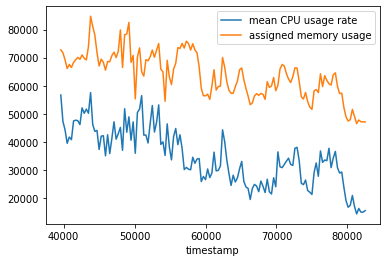

In [24]:
time3.plot()

In [59]:
#build model
import matplotlib.pyplot as plt 
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation, ConvLSTM2D
from keras import backend as K
from keras.layers import LeakyReLU, BatchNormalization

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

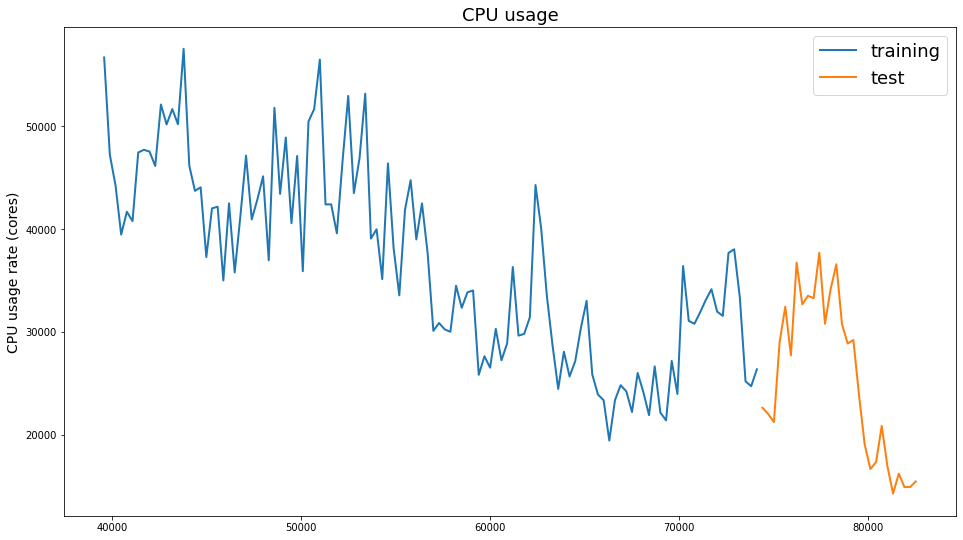

In [37]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data
def line_plot(line1, line2, label1=None, label2=None, title=''):
    fig, ax = plt.subplots(1, figsize=(16, 9))
    ax.plot(line1, label=label1, linewidth=2)
    ax.plot(line2, label=label2, linewidth=2)
    ax.set_ylabel('CPU usage rate (cores)', fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18)

train, test = train_test_split(clean_df, test_size=0.2)
line_plot(train['mean CPU usage rate'], test['mean CPU usage rate'], 'training', 'test', 'CPU usage')

In [64]:
def normalise_zero_base(df):
    """ Normalise dataframe column-wise to reflect changes with
        respect to first entry.
    """
    return df / df.iloc[0] - 1
def extract_window_data(df, window=20, zero_base=True):
    """ Convert dataframe to overlapping sequences/windows of
        length `window`.
    """
    window_data = []
    for idx in range(len(df) - window):
        tmp = df[idx: (idx + window)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)
def prepare_data(df, window=20, zero_base=True, test_size=0.2):
    """ Prepare data for LSTM. """
    # train test split
    train_data, test_data = train_test_split(df, test_size)
    
    # extract window data
    X_train = extract_window_data(train_data, window, zero_base)
    X_test = extract_window_data(test_data, window, zero_base)
    
    # extract targets
    y_train = train_data['mean CPU usage rate'][window:].values
    y_test = test_data['mean CPU usage rate'][window:].values
    if zero_base:
        y_train = y_train / train_data['mean CPU usage rate'][:-window].values - 1
        y_test = y_test / test_data['mean CPU usage rate'][:-window].values - 1
    return train_data, test_data, X_train, X_test, y_train, y_test
train, test, X_train, X_test, y_train, y_test = prepare_data(clean_df)

In [65]:
X_train.shape

(96, 20, 2)

In [ ]:
modelC = keras.models.load_model('path/to/location')

In [44]:
def build_lstm_model(input_data, output_size, neurons=64,
                     activ_func='tanh', dropout=0.2,
                     loss='mae', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, input_shape=(
              input_data.shape[1], input_data.shape[2])))
    model.add(LSTM(64))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    #model.add(LeakyReLU(alpha=.1))
    model.compile(loss=loss, optimizer=optimizer)
    return model
model = build_lstm_model(X_train, output_size=1)
history = model.fit(X_train, y_train, epochs=700, batch_size=64)

ch 451/700
2/2 [==============================] - 0s 7ms/step - loss: 0.0920
Epoch 452/700
2/2 [==============================] - 0s 6ms/step - loss: 0.0897
Epoch 453/700
2/2 [==============================] - 0s 7ms/step - loss: 0.0914
Epoch 454/700
2/2 [==============================] - 0s 6ms/step - loss: 0.0926
Epoch 455/700
2/2 [==============================] - 0s 7ms/step - loss: 0.0911
Epoch 456/700
2/2 [==============================] - 0s 6ms/step - loss: 0.0902
Epoch 457/700
2/2 [==============================] - 0s 6ms/step - loss: 0.0919
Epoch 458/700
2/2 [==============================] - 0s 7ms/step - loss: 0.0925
Epoch 459/700
2/2 [==============================] - 0s 7ms/step - loss: 0.0924
Epoch 460/700
2/2 [==============================] - 0s 7ms/step - loss: 0.0913
Epoch 461/700
2/2 [==============================] - 0s 6ms/step - loss: 0.0901
Epoch 462/700
2/2 [==============================] - 0s 7ms/step - loss: 0.0909
Epoch 463/700
2/2 [========================

0.5064323455945909
0.6570433126562617


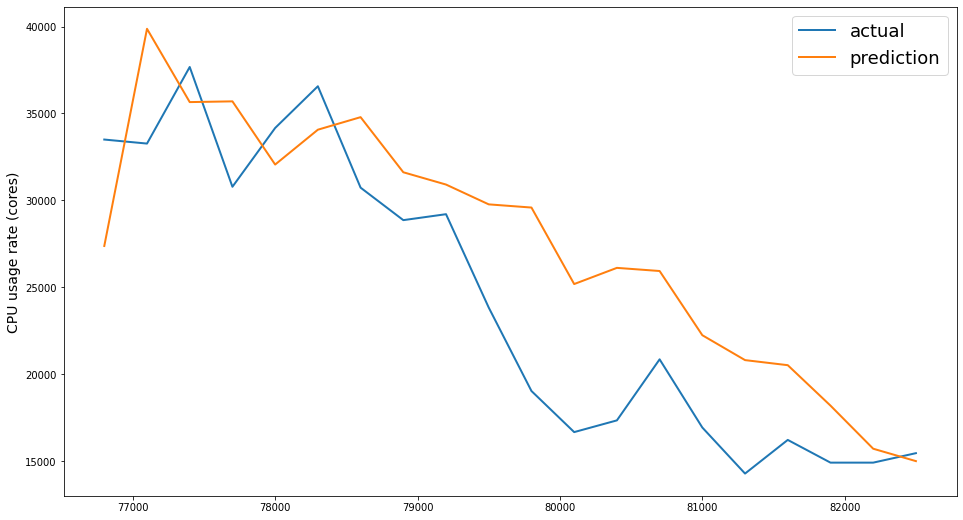

In [45]:
window=8
target_col='mean CPU usage rate'
targets = test[target_col][window:]


preds = model.predict(X_train).squeeze()
predsTest = model.predict(X_test).squeeze()

print(r2_score(preds, y_train))
print(r2_score(predsTest, y_test))

# convert change predictions back to actual val
predsTest = test['mean CPU usage rate'].values[:-window] * (predsTest + 1)
predsTest = pd.Series(index=targets.index, data=predsTest)

n = 180
line_plot(targets[-n:], predsTest[-n:], 'actual', 'prediction')

In [58]:
window=8
target_col='mean CPU usage rate'
targets = test[target_col][window:]


predsC = modelC.predict(X_train).squeeze()
predsTestC = modelC.predict(X_test).squeeze()

print(r2_score(predsC, y_train))
print(r2_score(predsCTest, y_test))

# convert change predictions back to actual val
predsCTest = test['mean CPU usage rate'].values[:-window] * (predsCTest + 1)
predsCTest = pd.Series(index=targets.index, data=predsCTest)

n = 180
line_plot(targets[-n:], predsCTest[-n:], 'actual', 'prediction')

ValueError: in user code:

    C:\Python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1462 predict_function  *
        return step_function(self, iterator)
    C:\Python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1445 run_step  **
        outputs = model.predict_step(data)
    C:\Python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1418 predict_step
        return self(x, training=False)
    C:\Python38\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    C:\Python38\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:176 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_11 is incompatible with the layer: expected ndim=5, found ndim=3. Full shape received: [None, 8, 2]


In [36]:
preds

array([-0.11250152, -0.11744889, -0.11886407, -0.07085672, -0.09360091,
       -0.07253887, -0.13541226, -0.12728788, -0.10795438, -0.0683108 ,
       -0.15717845, -0.10201319, -0.12330822, -0.05693828, -0.11458516,
       -0.04065164, -0.0408031 , -0.0181754 ,  0.05497541,  0.08721401,
        0.18066204,  0.23876293,  0.08072509,  0.00126039, -0.01784659,
       -0.02340611, -0.03664116, -0.05055932, -0.08994096, -0.01435317,
       -0.11375343, -0.10278167, -0.144     , -0.06441812, -0.11074885,
        0.13283809, -0.12887916, -0.14392366, -0.3043526 , -0.07891786,
       -0.11337002, -0.10695249, -0.22563182, -0.3873224 , -0.2630392 ,
       -0.35666594, -0.4956114 , -0.23661295, -0.26979887, -0.13423781,
       -0.43595725, -0.1926797 , -0.04336041, -0.2675246 , -0.31977558,
       -0.07321187, -0.12186271, -0.02945873, -0.02378547, -0.02140978,
       -0.02171444, -0.03149504, -0.05749812, -0.09716213, -0.13310586,
       -0.14980432, -0.07740902, -0.08848732, -0.07030351, -0.12

In [13]:
from sklearn import preprocessing as pp 

min_max_scaler=pp.MinMaxScaler()

def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

norm_frame=normalize(time_grouped)
norm_frame.head()

,util:CPU,util:memory,util:disk,load1avg,load5avg,load15avg
timestamp,,,,,,
39600,0.980522,0.687013,0.973985,1.000000,1.000000,0.973439
39900,0.761847,0.659420,0.972159,0.786310,0.850912,0.928518
40200,0.693161,0.593942,0.971019,0.741886,0.778775,0.894053
40500,0.582242,0.513262,0.971268,0.610783,0.702540,0.872232
40800,0.633706,0.549865,0.971323,0.637045,0.656730,0.841899


<AxesSubplot:xlabel='timestamp'>

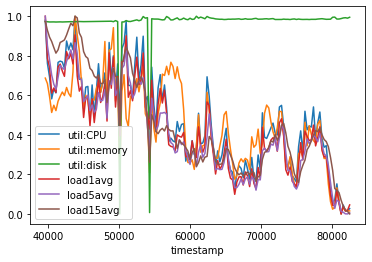

In [15]:
norm_frame.plot()